In [0]:
import torch
from torchsummary import summary
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [0]:
encoder = {
    'happy': 0,
    'surprised' : 1,
    'angry': 2,
    'sad': 3,
    'Unknown': 4

}
decoder = {
    0 : 'happy',
    1 : 'surprised' ,
    2 : 'angry',
    3 : 'sad',
    4 : 'Unknown'

}

In [0]:
import pandas as pd
file_path_test = "/content/Train.csv"
root_dir_test = "/content"
csv_file = pd.read_csv(file_path_test)
csv_file.head()

,Frame_ID,Emotion
0,frame0.jpg,happy
1,frame1.jpg,happy
2,frame2.jpg,surprised
3,frame3.jpg,surprised
4,frame4.jpg,angry


In [0]:
import pandas as pd
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
train_img = []
train_aug = []

transformation = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.CenterCrop((400,700)),
                                      transforms.Resize((224,224), interpolation=2),
                                      transforms.ToTensor()
                                    ])

for i in range(0 , 298):
  frame = csv_file.iloc[i,0]
  label = csv_file.iloc[i,1]
  image = root_dir_test  + '/' + frame
  img =  cv2.imread(image)
  #plt.imshow(img)
  imagetensor1 = transformation(img)
  imagetensor1 = np.transpose(imagetensor1,(1,2,0))
  train_aug.append(img)
  #plt.imshow(im_convert(imagetensor))
  imagenumpy = imagetensor1.numpy()
  imagenew = imagenumpy
  train_img.append(imagenew)
 
  

train_x = np.array(train_img )

train_y = csv_file['Emotion'].values
train_x.shape, train_y.shape
  

((298, 224, 224, 3), (298,))

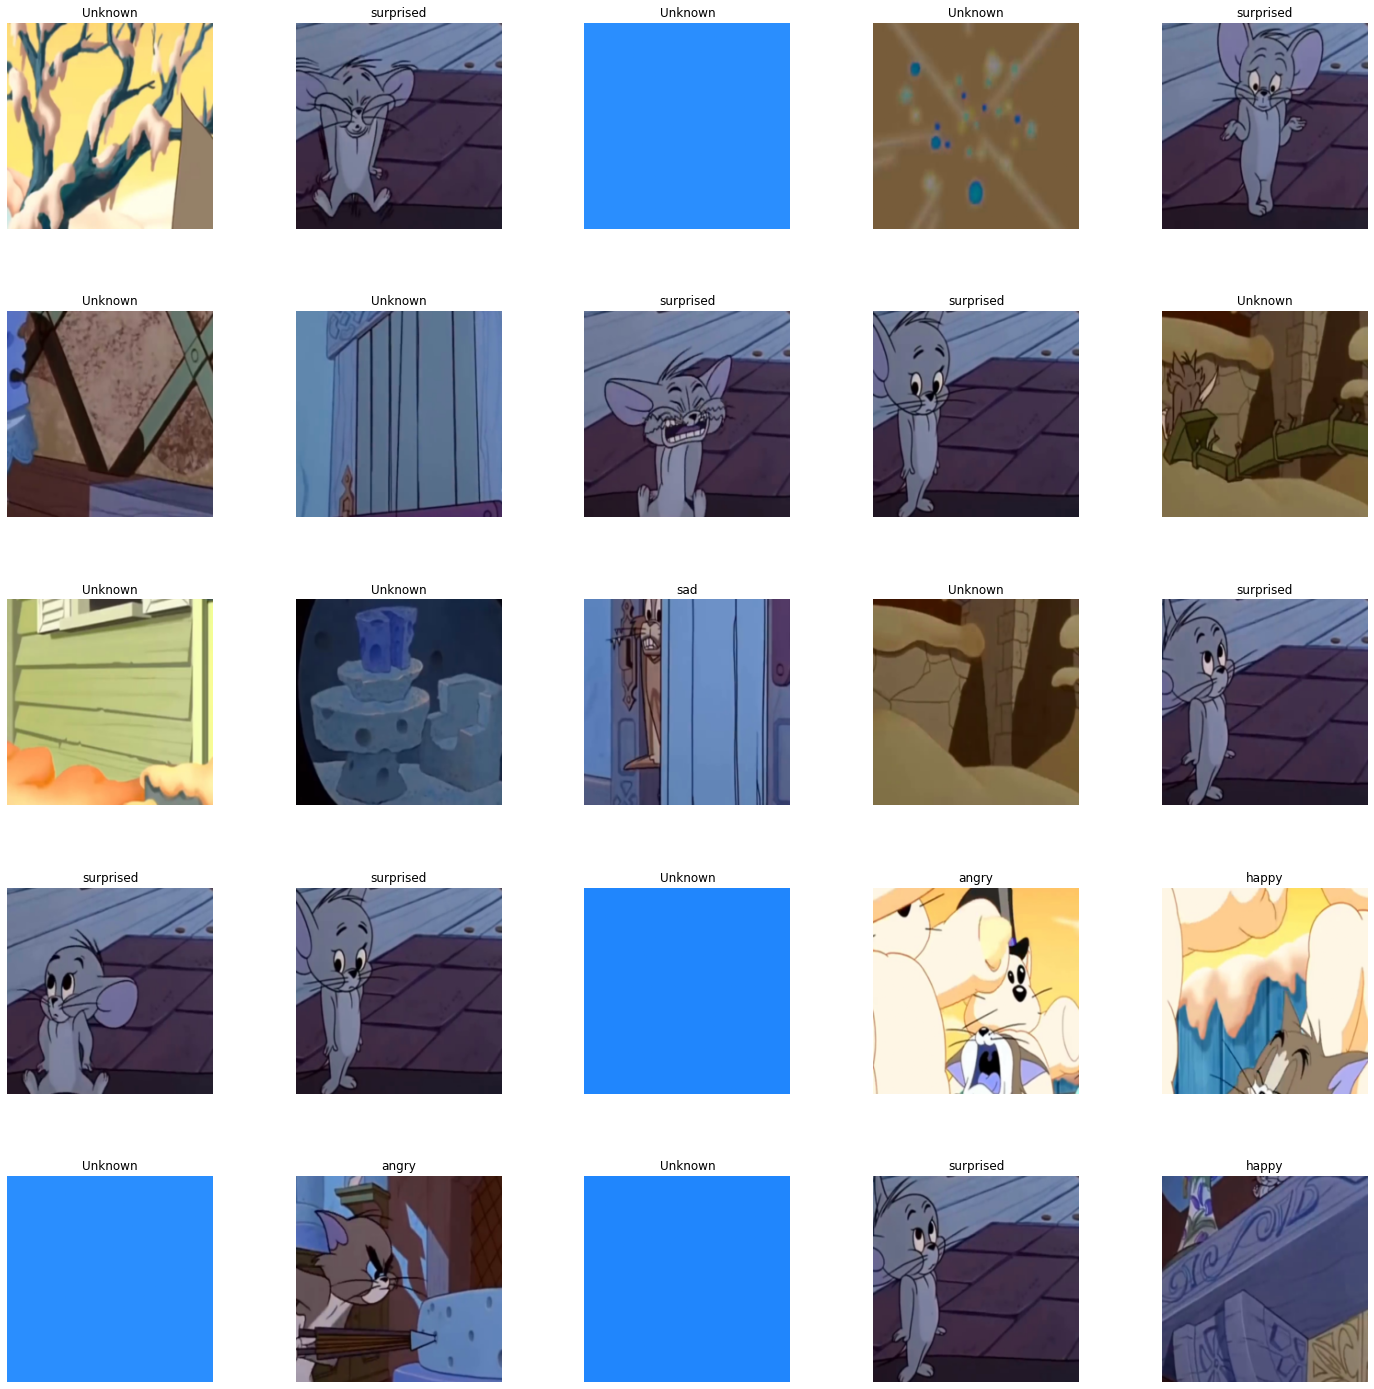

In [0]:
L_grid = 5
W_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize=(25,25))
axes = axes.ravel()
n_training = len(train_x)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(train_img[index])
    axes[i].set_title(train_y[index])
    axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)

In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        RandomRotate90(),
        
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

    
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    return image

In [0]:
train_aug_new = []
aug_final = []

for i in range( 0,  298):
  image = train_aug[i]
  aug = augment_flips_color(p=1)
  x = augment_and_show(aug, image)
  #plt.imshow(x)
  imagetensor = transformation(x)
  imagetensor = np.transpose(imagetensor,(1,2,0))
  #plt.imshow(im_convert(imagetensor))
  imagenumpy = imagetensor.numpy()
  imagenew = imagenumpy
  train_aug_new.append(imagenew)


aug_final = np.array(train_aug_new)



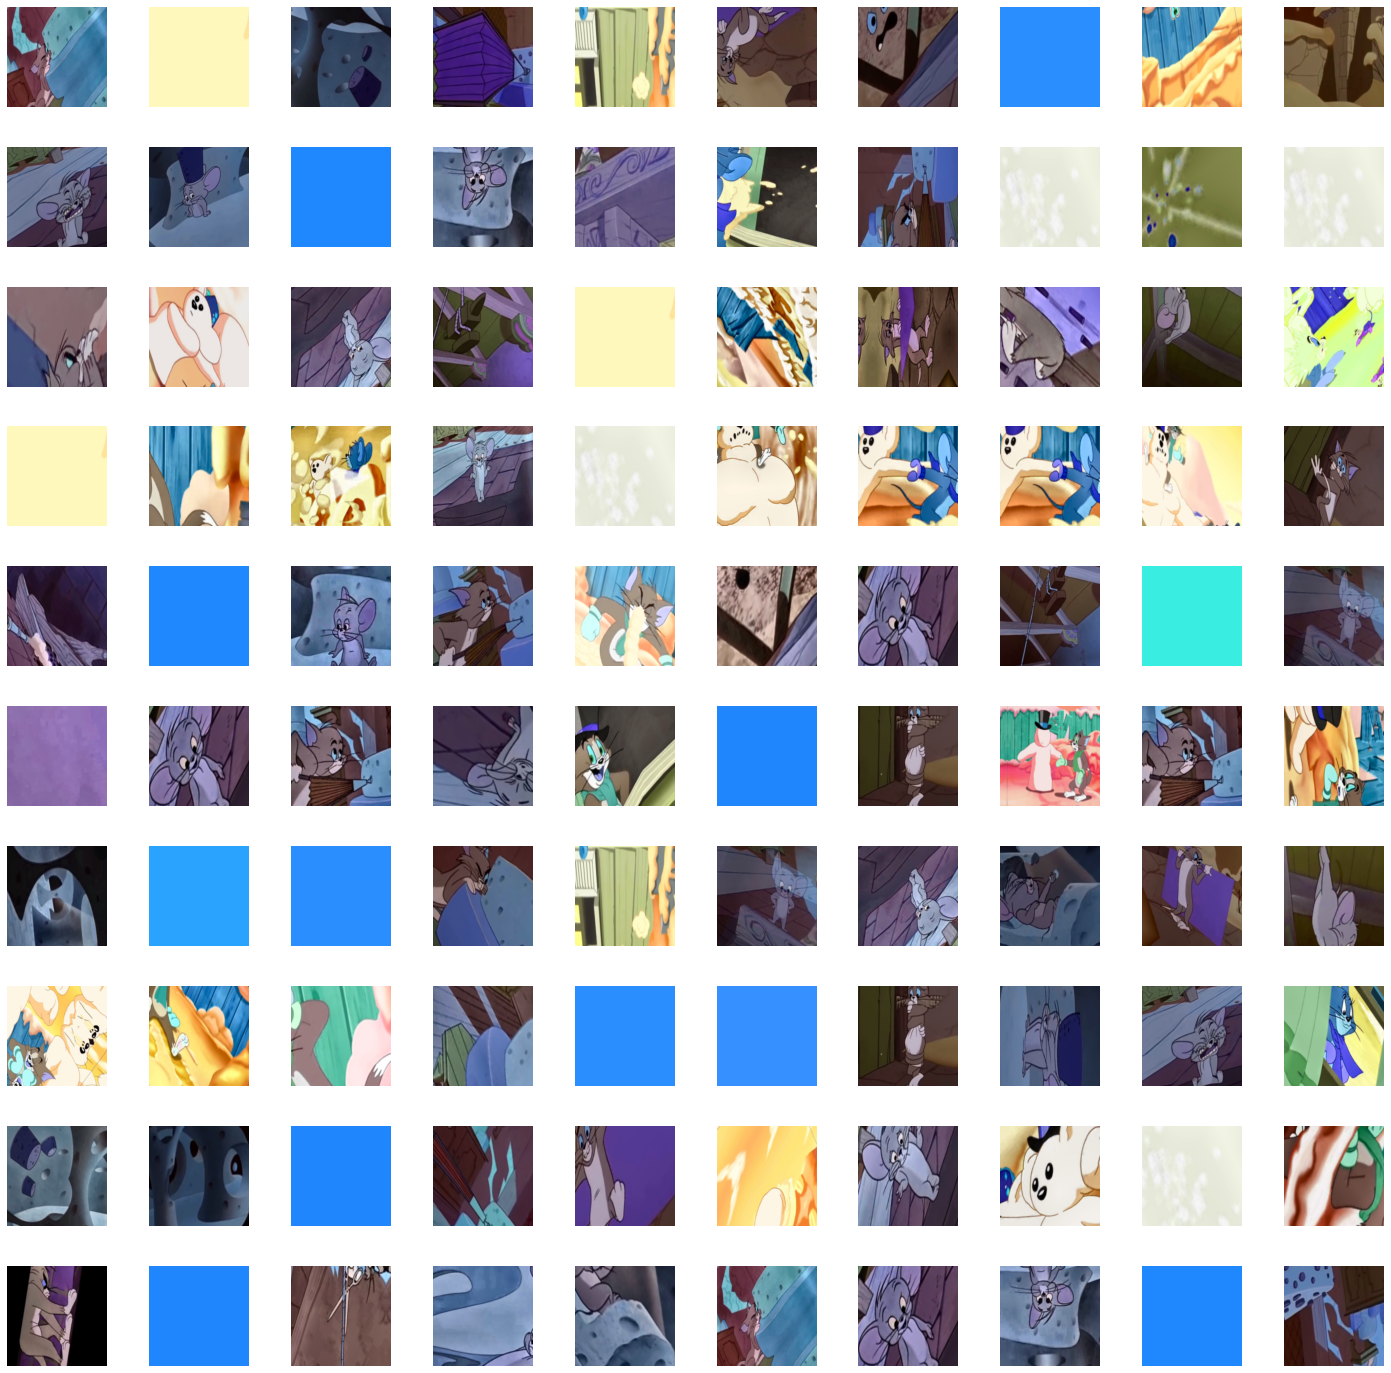

In [0]:
L_grid = 10
W_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize=(25,25))
axes = axes.ravel()
n_training = len(train_x)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(aug_final[index])

    axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)

In [0]:
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

final_train_data = []
final_target_train = []
#apply shift operation
transform1 = AffineTransform(translation=(25,25))
transform2 = AffineTransform(translation=(50,50))
transform3 = AffineTransform(translation=(100,100))
transform4 = AffineTransform(translation=(120,120))

for i in tqdm(range(train_x.shape[0])):
    final_train_data.append(train_x[i])
    final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(train_x[i]))
    final_train_data.append(np.flipud(train_x[i]))
    final_train_data.append(gaussian(train_x[i],sigma=1,multichannel=True))
    final_train_data.append(warp(train_x[i],transform1,mode='wrap'))
    final_train_data.append(warp(train_x[i],transform2,mode='wrap'))
    final_train_data.append(warp(train_x[i],transform3,mode='wrap'))
    final_train_data.append(warp(train_x[i],transform4,mode='wrap'))
    final_train_data.append(random_noise(train_x[i],var=0.2**2))
    final_train_data.append(aug_final[i])
     
    for j in range(11):
        final_target_train.append(encoder[train_y[i]])

100%|██████████| 298/298 [00:15<00:00, 19.52it/s]


In [0]:
len(final_target_train), len(final_train_data)
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)
print(len(final_train))
print(len(final_target_train))

3278
3278


In [0]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [0]:
final_train = final_train.reshape(len(final_train), 3, 224, 224)
final_train  = torch.from_numpy(final_train)
final_train = final_train.float()

# converting the target into torch format
final_target_train = final_target_train.astype(int)
final_target_train = torch.from_numpy(final_target_train)

In [0]:
from torchvision import models
vgg16 = models.vgg16_bn(pretrained=True)

In [0]:
import torch
import torch.nn as nn
vgg16 = models.vgg16_bn()

#the_model= torch.load("/content/model.pth")
vgg16.load_state_dict(torch.load("/root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 5)]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
#print(vgg16)

1000


In [0]:
model = vgg16
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.000075)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
torch.manual_seed(0)

# batch size of the model
batch_size = 64

# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
        
    permutation = torch.randperm(final_train.size()[0])

    training_loss = []
    for i in tqdm(range(0,final_train.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = final_train[indices], final_target_train[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 1 	 training loss: 	 0.024746217782824084


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 2 	 training loss: 	 0.006899647307223999


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 3 	 training loss: 	 0.004075203664027727


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 4 	 training loss: 	 0.004339113043477902


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 5 	 training loss: 	 0.00368470428377175


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 6 	 training loss: 	 0.0031288116252443823


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 7 	 training loss: 	 0.0034099453956654402


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 8 	 training loss: 	 0.0038377866686250153


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 9 	 training loss: 	 0.0036769942637944883


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 10 	 training loss: 	 0.0025767842717046873


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 11 	 training loss: 	 0.0058558720540112024


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 12 	 training loss: 	 0.005699085716444712


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 13 	 training loss: 	 0.005214223351616126


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 14 	 training loss: 	 0.00540482287760824


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 15 	 training loss: 	 0.004784155176541669


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 16 	 training loss: 	 0.004543942772845464


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 17 	 training loss: 	 0.004688886710657523


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 18 	 training loss: 	 0.004605076183662067


  0%|          | 0/52 [00:00<?, ?it/s]

epoch: 	 19 	 training loss: 	 0.004688306041106653


100%|██████████| 52/52 [00:28<00:00,  1.86it/s]

epoch: 	 20 	 training loss: 	 0.004579045763770969


In [0]:
PATH = '/content/model.pth'
torch.save(model , PATH)
the_model= torch.load(PATH)

In [0]:
torch.manual_seed(0)
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(final_train.size()[0])
for i in tqdm(range(0,final_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = final_train[indices], final_target_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 52/52 [00:09<00:00,  5.53it/s]

training accuracy: 	 0.9990985576923077


In [0]:
test_transforms = transforms.Compose([
                                      transforms.CenterCrop((700)),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor
    input = input.to('cuda')
    output = the_model(input)
    index = output.data.cpu().numpy().argmax()
  
    return index


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
file_path_test = "/Test.csv"
root_dir_test = "/"
i = 0
result = []
image_file = []
csv_file_test = pd.read_csv(file_path_test)
#Testing File


for i in range(0,len(csv_file_test)):
  
  frame = csv_file_test.iloc[i,0]
  image = root_dir_test  + '/' + frame
  imagetensor = cv2.imread(image)
  #img = Image.open(image)
  #plt.imshow(img)
  to_pil = transforms.Compose([transforms.ToPILImage()])
  images = imagetensor
  #fig=plt.figure(figsize=(10,10))
  image = to_pil(images)
  #plt.imshow(image)
  index = predict_image(image)
  image_file.append(frame)
  result.append(decoder[index])



dict = {'Frame_ID': image_file, 'Emotion': result}
df = pd.DataFrame(dict) 
  
# saving the dataframe 
df.to_csv('file56.csv') 
df


,Frame_ID,Emotion
0,test0.jpg,surprised
1,test1.jpg,surprised
2,test2.jpg,surprised
3,test3.jpg,surprised
4,test4.jpg,surprised
...,...,...
181,test181.jpg,Unknown
182,test182.jpg,Unknown
183,test183.jpg,surprised
184,test184.jpg,surprised


In [0]:
test_img = []
tforms = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.CenterCrop((480,640)),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])
for i in range(0,len(csv_file_test)):
  frame = csv_file_test.iloc[i,0]
  image = root_dir_test  + '/' + frame
  imagetensor = cv2.imread(image)
  imagetensor = tforms(imagetensor)
  imagetensor = np.transpose(imagetensor,(1,2,0))
  test_img.append(imagetensor)
  


In [0]:
L_grid = 10
W_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize=(25,25))
axes = axes.ravel()
n_training = len(test_img)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(test_img[index])
    axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)